
Chatbot With Tool

In [1]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph,START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [4]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.1-8b-instant")

c:\Users\ASUS\.conda\envs\graph-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tool

ALWAYS provide a docstring with tools

In [7]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeli

In [8]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [9]:
tools=[tool,multiply]

In [10]:
llm_with_tool=llm.bind_tools(tools)

Build the graph

In [11]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [12]:
## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

In [13]:
## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


In [14]:
## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

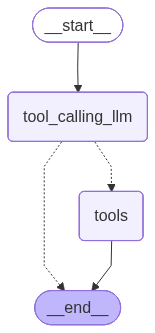

In [15]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Inference

In [16]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [18]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2026/01/24/a-new-test-for-ai-labs-are-you-even-trying-to-make-money/", "title": "A new test for AI labs: Are you even trying to make money? - TechCrunch", "score": 0.6867278, "published_date": "Sat, 24 Jan 2026 17:00:00 GMT", "content": "## Humans&\\n\\nHumans& was the big AI news this week, and part of the inspiration for coming up with this whole scale. The founders have a compelling pitch for the next generation of AI models, with scaling laws giving way to an emphasis on communication and coordination tools.\\n\\nBut for all the glowing press, Humans& has been coy about how that would translate into actual monetizable products. It seems it does want to build products; the team just won’t commit to anything specific. The most they’ve said is that they will be building some kind of AI workplace tool, replacing products like Slack, Jira and Google Docs bu

In [19]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (1yhx6qq5k)
 Call ID: 1yhx6qq5k
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2026/01/24/a-new-test-for-ai-labs-are-you-even-trying-to-make-money/", "title": "A new test for AI labs: Are you even trying to make money? - TechCrunch", "score": 0.6867278, "published_date": "Sat, 24 Jan 2026 17:00:00 GMT", "content": "## Humans&\n\nHumans& was the big AI news this week, and part of the inspiration for coming up with this whole scale. The founders have a compelling pitch for the next generation of 

In [20]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (tpnfwafcb)
 Call ID: tpnfwafcb
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [21]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (cbybjnncm)
 Call ID: cbybjnncm
  Args:
    query: recent AI news
    time_range: day
    topic: news
  multiply (gshq0w5wv)
 Call ID: gshq0w5wv
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2026/01/24/a-new-test-for-ai-labs-are-you-even-trying-to-make-money/", "title": "A new test for AI labs: Are you even trying to make money? - TechCrunch", "score": 0.9759464, "published_date": "Sat, 24 Jan 2026 17:00:00 GMT", "content": "On the other side, you might argue that Meta’s early AI research was firmly at Level 2, when what the company rea